<a href="https://colab.research.google.com/github/ohudalraddadi-hub/ai-arabic-text-detection/blob/main/Phase_1_Data_Acquisition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1.2: Download Dataset using Hugging Face datasets library

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the Arabic-generated abstracts dataset
dataset = load_dataset("KFUPM-JRCAI/arabic-generated-abstracts")

# Task 1.3: Data Exploration

## 1. Inspect dataset structure

In [ ]:
 dataset.keys()

dict_keys(['by_polishing', 'from_title', 'from_title_and_content'])

In [ ]:
#Show available splits
dataset.values()

dict_values([Dataset({
    features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
    num_rows: 2851
}), Dataset({
    features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
    num_rows: 2963
}), Dataset({
    features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
    num_rows: 2574
})])

In [ ]:
print(dataset["by_polishing"].shape)
print(dataset["from_title"].shape)
print(dataset["from_title_and_content"].shape)

(2851, 5)
(2963, 5)
(2574, 5)


Save the raw dataset

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [87]:
cd /content/drive/MyDrive/Colab Notebooks/data/00_raw_Phase_0/HF Format


/content/drive/MyDrive/Colab Notebooks/data/00_raw_Phase_0/HF Format


In [88]:
# Save the entire dataset (all splits) to disk (Hugging Face’s Arrow format)
dataset.save_to_disk("arabic_generated_abstracts_raw")

Saving the dataset (0/1 shards):   0%|          | 0/2851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2963 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2574 [00:00<?, ? examples/s]

In [89]:
cd /content/drive/MyDrive/Colab Notebooks/data/00_raw_Phase_0

/content/drive/MyDrive/Colab Notebooks/data/00_raw_Phase_0


In [90]:
# Save the dataset as plain CSV files
for split, ds in dataset.items():
    ds.to_csv(f"arabic_generated_abstracts_raw_{split}.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

## 2. Reshape each split into a binary long format (human vs AI)

In [91]:
# Combine all splits
dfs = []
for split_name, dset in dataset.items():
    temp = pd.DataFrame(dset)
    temp["split_name"] = split_name

    # Human abstracts
    temp_human = temp[["original_abstract"]].rename(columns={"original_abstract": "text"})
    temp_human["label"] = 0  # Human
    temp_human["model_name"] = "human"
    temp_human["split_name"] = split_name
    dfs.append(temp_human)

    # AI-generated abstracts for each model
    for model in ["allam", "jais", "llama", "openai"]:
        col = f"{model}_generated_abstract"
        temp_ai = temp[[col]].rename(columns={col: "text"})
        temp_ai["label"] = 1
        temp_ai["model_name"] = model
        temp_ai["split_name"] = split_name
        dfs.append(temp_ai)

# Concatenate everything
data_long = pd.concat(dfs, ignore_index=True)
data_long.shape

(41940, 4)

In [92]:
data_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41940 entries, 0 to 41939
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        41940 non-null  object
 1   label       41940 non-null  int64 
 2   model_name  41940 non-null  object
 3   split_name  41940 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


## 3. Data Distribution

3.1 Distribution by Class (human vs AI)

In [93]:
data_long['label_name'] = data_long['label'].map({0: 'Human', 1: 'AI'})
data_long['label_name'].value_counts()

,count
label_name,
AI,33552
Human,8388


<Axes: title={'center': 'Overall Distribution: Human vs AI'}, xlabel='Class', ylabel='Count'>

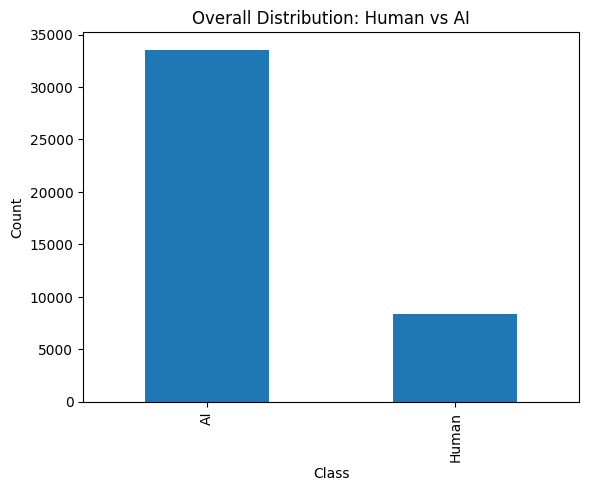

In [94]:
data_long['label_name'].value_counts().plot(
    kind='bar',
    title='Overall Distribution: Human vs AI',
    ylabel='Count',
    xlabel='Class')

3.2 Distribution by split

In [95]:
data_long.groupby(['split_name','label_name']).size().unstack(fill_value=0)

label_name,AI,Human
split_name,,
by_polishing,11404,2851
from_title,11852,2963
from_title_and_content,10296,2574


<Axes: title={'center': 'Split Class Distribution'}, xlabel='split_name', ylabel='Count'>

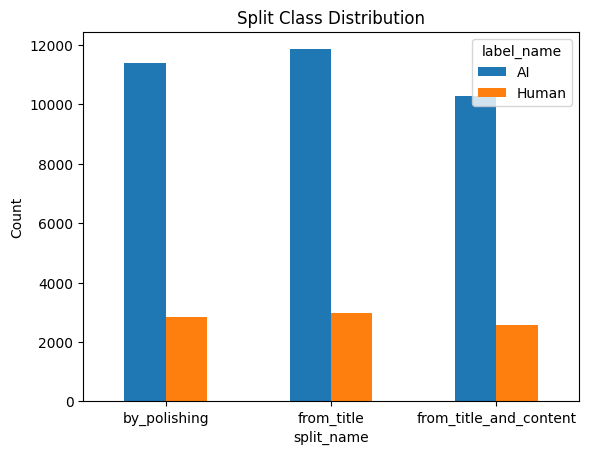

In [96]:
data_long.groupby(['split_name', 'label_name']).size().unstack().plot(
    kind='bar',
    title='Split Class Distribution',
    ylabel='Count',
    rot=0
)

3.3 Distribution by Split and Model

In [97]:
data_long.groupby(["split_name", "model_name"]).size().unstack(fill_value=0)


model_name,allam,human,jais,llama,openai
split_name,,,,,
by_polishing,2851,2851,2851,2851,2851
from_title,2963,2963,2963,2963,2963
from_title_and_content,2574,2574,2574,2574,2574


## 4. Data quality

4.1 Missing values

In [98]:
# Missing values per split
data_long.groupby("split_name").apply(lambda x: x.isnull().sum())

/tmp/ipython-input-2909048689.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_long.groupby("split_name").apply(lambda x: x.isnull().sum())


,text,label,model_name,split_name,label_name
split_name,,,,,
by_polishing,0,0,0,0,0
from_title,0,0,0,0,0
from_title_and_content,0,0,0,0,0


4.2 Duplicates

In [99]:
# Separate by label
human_dups = data_long[data_long["label"] == 0].duplicated(subset=["text"], keep=False)
ai_dups = data_long[data_long["label"] == 1].duplicated(subset=["text"], keep=False)

print("Human duplicates:", human_dups.sum())
print("AI duplicates:", ai_dups.sum())


Human duplicates: 8352
AI duplicates: 4


In [100]:
# Find identical texts within the same category
dups = data_long[data_long.duplicated(subset=["text", "label", "split_name"], keep=False)]
dups.groupby(["split_name", "label"]).size()

,,0
split_name,label,
from_title_and_content,1,4


In [101]:
dups

,text,label,model_name,split_name,label_name
35460,، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ...,1,jais,from_title_and_content,AI
36187,، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ...,1,jais,from_title_and_content,AI
36504,، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ...,1,jais,from_title_and_content,AI
36512,، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ، ...,1,jais,from_title_and_content,AI


In [102]:
# Find all duplicated groups (including originals)
dup_mask = data_long.duplicated(subset=["text", "label", "split_name"], keep=False)

# Drop ALL of them (keep only unique combinations)
data_clean = data_long[~dup_mask].reset_index(drop=True)

print("Before:", len(data_long))
print("After:", len(data_clean))

Before: 41940
After: 41936


In [103]:
# to see top duplicate texts:
data_long[data_long.duplicated(subset=['text'], keep=False)].sort_values('text').head(12)

,text,label,model_name,split_name,label_name
2828,"""غني عن القول أنّ القرآن من هذه النّاحية حجاج ...",0,human,by_polishing,Human
17194,"""غني عن القول أنّ القرآن من هذه النّاحية حجاج ...",0,human,from_title,Human
31624,"""غني عن القول أنّ القرآن من هذه النّاحية حجاج ...",0,human,from_title_and_content,Human
17191,(علم النص) آخر ما توصلت إليه اللسانيات الغربية...,0,human,from_title,Human
31621,(علم النص) آخر ما توصلت إليه اللسانيات الغربية...,0,human,from_title_and_content,Human
2825,(علم النص) آخر ما توصلت إليه اللسانيات الغربية...,0,human,by_polishing,Human
29288,.الاهتمام بالمخطوط العقدي والكلامي في المغرب ا...,0,human,from_title_and_content,Human
233,.الاهتمام بالمخطوط العقدي والكلامي في المغرب ا...,0,human,by_polishing,Human
14496,.الاهتمام بالمخطوط العقدي والكلامي في المغرب ا...,0,human,from_title,Human
2756,.تهدف الدراسة إلى التعرف على أثر التدريب المدم...,0,human,by_polishing,Human


In [104]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41936 entries, 0 to 41935
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        41936 non-null  object
 1   label       41936 non-null  int64 
 2   model_name  41936 non-null  object
 3   split_name  41936 non-null  object
 4   label_name  41936 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [105]:
cd /content/drive/MyDrive/Colab Notebooks/data/01_long_Phase_1

/content/drive/MyDrive/Colab Notebooks/data/01_long_Phase_1


Save a the new clean dataset

In [106]:
# Save per-split and combined parquet/csv
out_cols = ['text','label','model_name','split_name']
data_clean[out_cols].to_parquet('arabic_generated_abstracts_long_v2.parquet', index=False)
data_clean[out_cols].to_csv('arabic_generated_abstracts_long_v2.csv', index=False)
print("Saved: arabic_generated_abstracts_long_v2.(parquet|csv)")

Saved: arabic_generated_abstracts_long_v2.(parquet|csv)
